# 프로젝트 : 폐렴 진단기 성능개선

In [113]:
# !pip install IPython 
from IPython.display import Image  # 주피터 노트북에 이미지 삽입

## 개요
#### 이전 CNN모델을 통해 모델 학습을 하는 것을 확인하였고, 아래와 같이 결과가 나왔다.   
#### 이제 ResNet-18을 이용하여 정확도를 높이는 프로젝트를 진행한다.

#### Loss: 0.7886870503425598,  
#### Accuracy: 0.7804487347602844,  
#### Precision: 0.7446808218955994,  
#### Recall: 0.9871794581413269  

## 아래와 같이 프로젝트를 진행한다.
1. 실험환경 Set-up
    - Batch size, Epoch 등을 변경하면서 모델의 하이퍼 파라미터 값을 조정한다.
2. 데이터 준비하기
    - 원본 데이터를 가져와서 전처리 및 배치 구성을 진행한다. argument를 이용하여 모델의 부족한 데이터를 보충한다.
3. 데이터 시각화
    - 학습용 데이터를 시각화해서 확인해 본다.
4. ResNet-18 구현
    - ResNet-18을 구현하고 skip connection을 사용한다.
5. 데이터 imbalance 처리
    - 데이터의 비율이 맞지 않을 경우, class_weight를 설정해 주었습니다.
6. optimizer나 learning rate 
    - optimizer나 learning rate를 적절히 설정합니다.
7. 결과 확인과 시각화
    - 테스트 데이터로 훈련된 모델을 평가해 봅시다.

In [57]:
# 주요 라이브러리 버전을 확인해 봅시다.
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 실험환경 Set-up

In [58]:
# 패키지(라이브러리)들을 import 해보겠습니다.
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성합니다.

In [59]:

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# BATCH_SIZE와 EPOCHS에 변화를 줍니다.
BATCH_SIZE = 16 # 16 -> 32
EPOCHS = 10  # 10 -> 30

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [60]:
# 원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
# 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [61]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [62]:
# 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. 
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [63]:
# 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 
# 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [64]:
# 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 
# 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. 
# test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.
# tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [65]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [66]:
# 현재 이미지에는 라벨 데이터가 따로 없습니다.
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [67]:
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
# decode_img 함수와 process_path 함수를 만들겠습니다.
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [68]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # AUTOTUNE변수를 이용하여 더욱 빠르게 데이터를 처리합니다.
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [69]:
# 위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [70]:
# 좌우를 반전하는 argumentation을 도입합니다.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

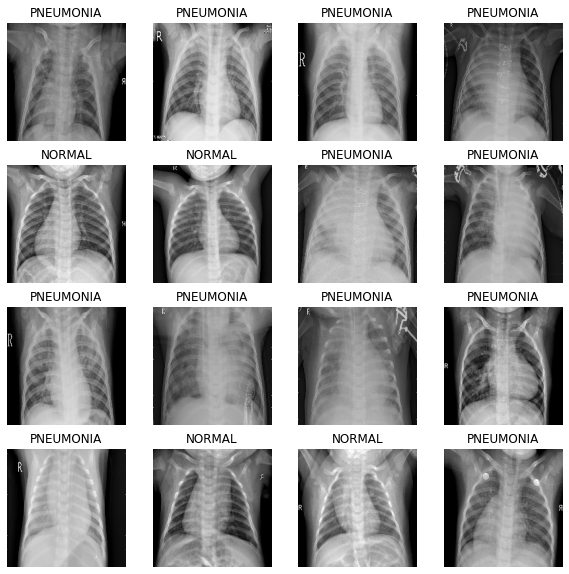

In [71]:
# 학습용 데이터를 시각화해서 확인해 봅니다.
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 
# 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
# 좌우 반전된 이미지가 있음을 확인할 수 있습니다.

## Step 4. ResNet-18 모델링

In [89]:
# ResNet을 통해 모델링을 하고 결과를 만들어 보겠습니다.
# 먼저, Convolution block을 만듭니다. 
# conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 
def residual_block(x, filters):
    shortcut = x
    
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Residual 연결
    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    # Resnet의 Residual block을 구현
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    return x

In [90]:
# Dense Block은 아래와 같이 만듭니다.
def dense_block(x, units, dropout_rate):
    x = tf.keras.layers.Dense(units, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [105]:
# 위의 Block들을 이용해서 모델을 만듭니다.
def build_resnet18(input_shape, num_classes):
    input_tensor = tf.keras.Input(shape=input_shape)
    
    # Conv1
    x = tf.keras.layers.Conv2D(64, (7,7), strides=2, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Conv2
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Conv3
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Conv4
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    # Conv5
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    
    # Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense 레이어 추가
    x = dense_block(x, 512, 0.2)
    x = dense_block(x, 128, 0.2)
    x = dense_block(x, 64, 0.2)
    
    # Output 레이어
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=input_tensor, outputs=output)
    return model

In [106]:
# 모델 빌드
input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1], 3)  # 입력 이미지 크기에 맞게 수정
num_classes = 1  # 분류할 클래스 수에 맞게 수정
model = build_resnet18(input_shape, num_classes)

# 모델 아키텍처 출력
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 90, 90, 64)   9472        input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_291 (BatchN (None, 90, 90, 64)   256         conv2d_183[0][0]                 
__________________________________________________________________________________________________
re_lu_175 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_291[0][0]    
___________________________________________________________________________________________

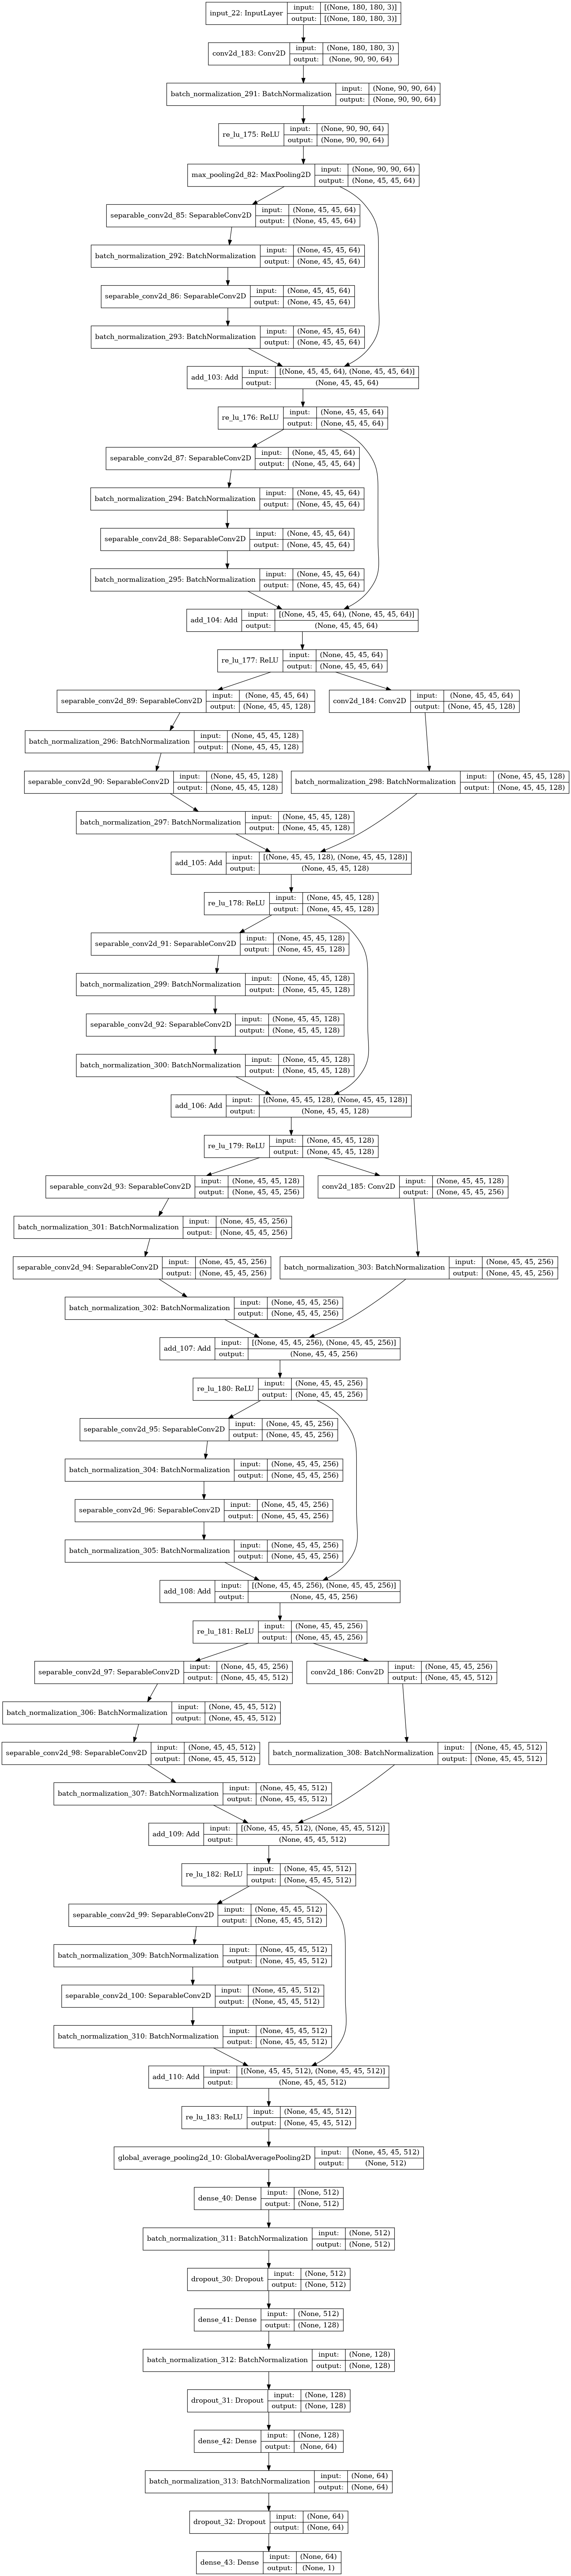

In [107]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='residual_module.png')

## Step 5. 데이터 imbalance 처리

In [108]:
# Weight balancing을 이용하여 데이터 imbalance를 처리합니다.
# 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다.   
- optimizer로 'adam'을 사용합니다.  
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [109]:
with tf.device('/GPU:0'):
    model = build_resnet18(input_shape, num_classes)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [110]:
# 모델을 fit 해보겠습니다.
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 98s 335ms/step - loss: 0.3335 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 1.3561 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 90s 346ms/step - loss: 0.2354 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 1.5570 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 90s 345ms/step - loss: 0.1943 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 1.2448 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 90s 345ms/step - loss: 0.1880 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 0.3186 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 90s 345ms/step - loss: 0.1761 - accura

## Step 7. 결과 확인과 시각화

- 결과를 그래프로 출력합니다.

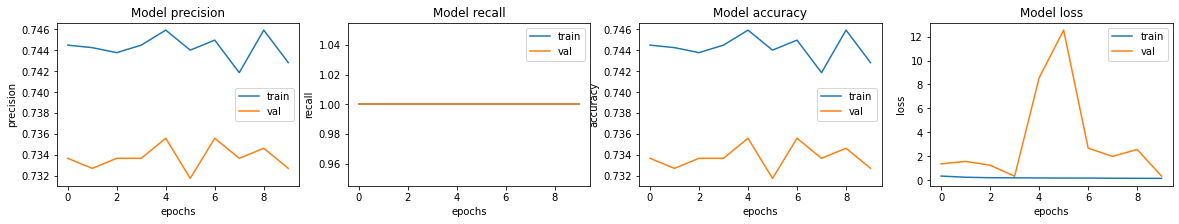

In [111]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가를 해보겠습니다.
- 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [112]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 1.5762 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.5762087106704712,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 회고

## 이번 프로젝트에서 느낀점
    이번 프로젝트를 진행하면서 느낀 점은 어려운만큼 유익한 경험이었다는 것이다. 처음에는 몇몇 개념과 기술들이 어려워 보였지만, 프로젝트를 진행하며 조금씩 이해하고 숙달되었다.  
    가장 어려웠던 부분은 모델을 구성하는 단계였는데, 특히 ResNet-18과 같은 복잡한 구조를 구현하려면 레이어의 배치와 연결을 정확하게 이해하고 구현해야 했다. 또한, 텐서플로우의 다양한 함수와 레이어들을 조합하여 모델을 구축하면서 여러 오류가 났는데 개념적으로 내가 부족한 부분을 많이 점검할 수 있었고, 복습이 필요한 부분이 많다고 생각했다.  
    하지만 이러한 어려움을 극복하며 더 많은 것을 배우고 성장할 수 있었던 것 같다. 처음에는 막막했지만 하나둘씩 오류를 수정하면서 완벽하지는 않지만 문제를 해결하고 결과를 얻는 과정에서 학습과 프로젝트 완성에 대한 성취감을 느낄 수 있었다.  

## ref

 [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)